<a href="https://colab.research.google.com/github/Romal27/DSGP-24-Retina94/blob/Validating-the-input/Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

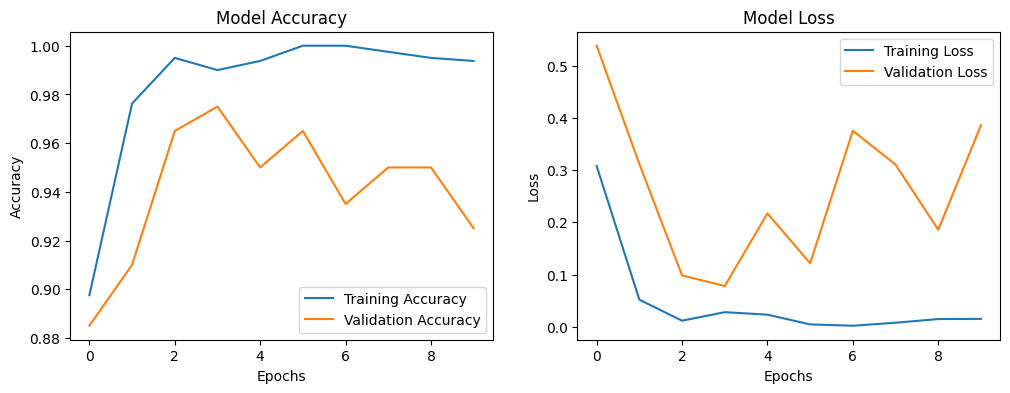

In [3]:

# Plotting accuracy and loss
plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define image size
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Preprocess data
datagen = ImageDataGenerator(
    rescale=1./255, 
    validation_split=0.2,
    rotation_range=15, 
    horizontal_flip=True,
    zoom_range=0.2
)

train_generator = datagen.flow_from_directory(
    'D:/Datasets_Retina', 
    target_size=IMG_SIZE, 
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training'
)

val_generator = datagen.flow_from_directory(
    'D:/Datasets_Retina', 
    target_size=IMG_SIZE, 
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation'
)

# Load EfficientNetB0 without the top layer
base_model = tf.keras.applications.EfficientNetB0(
    weights='imagenet', 
    include_top=False, 
    input_shape=(224, 224, 3)
)

# Freeze most layers to prevent overfitting
for layer in base_model.layers[:150]:  
    layer.trainable = False
# Feature extraction
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Reduce complexity
x = Dropout(0.3)(x)  # Prevent overfitting
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(1, activation='sigmoid')(x)  # Corrected output layer connection

# Create final model
model = Model(inputs=base_model.input, outputs=output)

# Create final model
model = Model(inputs=base_model.input, outputs=output)

# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train model
model.fit(train_generator, validation_data=val_generator, epochs=10)

# Evaluate the model
loss, accuracy = model.evaluate(val_generator)
print(f"Validation Accuracy: {accuracy * 100:.2f}%")


KeyboardInterrupt: 

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Define image size and batch size
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Data augmentation and preprocessing
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.3
)

train_generator = datagen.flow_from_directory(
    'D:/Datasets_Retina',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training'
)

val_generator = datagen.flow_from_directory(
    'D:/Datasets_Retina',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    shuffle=False
)

# Load EfficientNetB0 without the top layer
base_model = tf.keras.applications.EfficientNetB0(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

# Freeze most layers to prevent overfitting
for layer in base_model.layers[:150]:
    layer.trainable = False

# Feature extraction
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)  # Increased dropout for better regularization
x = Dense(256, activation='relu')(x)
x = Dropout(0.4)(x)
output = Dense(1, activation='sigmoid')(x)

# Create final model
model = Model(inputs=base_model.input, outputs=output)

# Compile model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Callbacks to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Train model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[early_stopping, reduce_lr]
)

# Evaluate model
test_loss, test_accuracy = model.evaluate(val_generator)
train_loss, train_accuracy = model.evaluate(train_generator)
print(f"Training Accuracy: {train_accuracy * 100:.2f}%")
print(f"Validation Accuracy: {test_accuracy * 100:.2f}%")

# Get predictions
y_true = val_generator.classes
y_pred = model.predict(val_generator)
y_pred = (y_pred > 0.5).astype(int).flatten()

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

Found 5722 images belonging to 2 classes.
Found 1430 images belonging to 2 classes.


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 411s 2s/step - accuracy: 0.7032 - loss: 0.5229 - val_accuracy: 0.4706 - val_loss: 0.7599 - learning_rate: 1.0000e-04
Epoch 2/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 364s 2s/step - accuracy: 0.8504 - loss: 0.3068 - val_accuracy: 0.4706 - val_loss: 1.5305 - learning_rate: 1.0000e-04
Epoch 3/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 375s 2s/step - accuracy: 0.8901 - loss: 0.2469 - val_accuracy: 0.6175 - val_loss: 0.5731 - learning_rate: 1.0000e-04
Epoch 4/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 332s 2s/step - accuracy: 0.9091 - loss: 0.2193 - val_accuracy: 0.9580 - val_loss: 0.1763 - learning_rate: 1.0000e-04
Epoch 5/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 320s 2s/step - accuracy: 0.9151 - loss: 0.2036 - val_accuracy: 0.6944 - val_loss: 0.5280 - learning_rate: 1.0000e-04
Epoch 6/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 324s 2s/step - accuracy: 0.9339 - loss: 0.1587 - val_accuracy: 0.4706 - val_loss: 3.0304 - learning_rate: 1.0000e-04
Epoch 7/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 321s 2s/step - acc